# NB01: Classify Experiments by Stress Category

Classify all 6,504 Fitness Browser experiments across 31 organisms into stress categories:
metal, antibiotic, osmotic, oxidative, carbon source, nitrogen source, pH, temperature, other.

Cross-validates metal classifications against the Metal Fitness Atlas.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Paths — prior project data lives in the main repo, not the worktree
PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
METAL_ATLAS = os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data')
FITNESS_MOD = os.path.join(MAIN_REPO, 'projects', 'fitness_modules', 'data')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')
os.makedirs(DATA_OUT, exist_ok=True)
os.makedirs(FIG_OUT, exist_ok=True)

print(f'Main repo: {MAIN_REPO}')
print(f'Metal atlas data: {os.path.exists(METAL_ATLAS)}')
print(f'Fitness module data: {os.path.exists(FITNESS_MOD)}')

Main repo: /home/psdehal/pangenome_science/BERIL-research-observatory
Metal atlas data: True
Fitness module data: True


## Load metal experiment classifications from the atlas

In [2]:
metal_exps = pd.read_csv(os.path.join(METAL_ATLAS, 'metal_experiments.csv'))
metal_exp_set = set(zip(metal_exps['orgId'], metal_exps['expName']))
print(f'Metal experiments from atlas: {len(metal_exp_set)}')
print(f'Organisms with metal data: {metal_exps["orgId"].nunique()}')
metal_exps.head(3)

Metal experiments from atlas: 559
Organisms with metal data: 31


,orgId,expName,expDesc,expGroup,condition_1,media,metal_element,metal_category,usgs_critical,match_method,concentration,conc_unit,cor12,mad12,nMapped
0,ANA3,set4IT074,Aluminum chloride 5 mM,stress,Aluminum chloride hydrate,LB,Aluminum,toxic,True,compound_match,5.00,mM,0.166038,0.208490,2988805
1,Caulo,set3IT050,PYE with Aluminum chloride 1.25 mM,stress,Aluminum chloride hydrate,PYE,Aluminum,toxic,True,compound_match,1.25,mM,0.697507,0.291038,2648702
2,Caulo,set4IT024,PYE with Aluminum chloride 1.25 mM,stress,Aluminum chloride hydrate,PYE,Aluminum,toxic,True,compound_match,1.25,mM,0.645727,0.276766,2406217


## Load all experiment annotations and classify

In [3]:
# Stress category keyword matching
ANTIBIOTIC_KEYWORDS = [
    'spectinomycin', 'piperacillin', 'cefoxitin', 'chloramphenicol', 'tetracycline',
    'kanamycin', 'ampicillin', 'erythromycin', 'rifampicin', 'ciprofloxacin',
    'vancomycin', 'gentamicin', 'streptomycin', 'trimethoprim', 'polymyxin',
    'nalidixic', 'novobiocin', 'penicillin', 'carbenicillin', 'sulfamethoxazole',
    'antibiotic', 'antimycin', 'cerulenin', 'triclosan', 'SDS', 'bile',
    'CCCP', 'FCCP', 'nigericin', 'valinomycin', 'gramicidin',
]

OSMOTIC_KEYWORDS = [
    'sodium chloride', 'NaCl', 'sucrose treatment', 'sorbitol',
    'polyethylene glycol', 'PEG', 'osmotic', 'glycerol',
    'KCl', 'potassium chloride',
]

OXIDATIVE_KEYWORDS = [
    'peroxide', 'H2O2', 'paraquat', 'menadione', 'diamide',
    'plumbagin', 'persulfate', 'peroxynitrite', 'DETA/NO',
    'nitric oxide', 'superoxide', 'oxidative',
    'diquat', 'cumene hydroperoxide', 'tert-butyl hydroperoxide',
]

PH_KEYWORDS = ['pH', 'acid stress', 'alkaline']

TEMPERATURE_KEYWORDS = ['temperature', 'heat shock', 'cold shock', 'thermotolerance']

DNA_DAMAGE_KEYWORDS = [
    'UV', 'mitomycin', 'cisplatin', 'MMS', 'methyl methanesulfonate',
    'hydroxyurea', 'bleomycin',
]

DETERGENT_SOLVENT_KEYWORDS = [
    'SDS', 'Triton', 'toluene', 'ethanol', 'butanol', 'DMSO',
    'chloroform', 'hexane', 'xylene',
]

def classify_experiment(row):
    """Classify a single experiment into a stress category."""
    org = row['orgId'] if 'orgId' in row.index else row.get('org', '')
    exp = row['expName']
    
    # Check if it's a metal experiment (from atlas)
    if (org, exp) in metal_exp_set:
        return 'metal'
    
    desc = str(row.get('expDesc', '')).lower()
    cond = str(row.get('condition_1', '')).lower()
    group = str(row.get('expGroup', '')).lower()
    text = f'{desc} {cond} {group}'
    
    # Use expGroup for carbon/nitrogen sources
    if group in ['carbon source', 'carbon_source']:
        return 'carbon_source'
    if group in ['nitrogen source', 'nitrogen_source']:
        return 'nitrogen_source'
    if group in ['sulfur source', 'sulfur_source']:
        return 'sulfur_source'
    if group in ['fermentative growth', 'respiratory growth', 'anaerobic']:
        return 'growth_mode'
    if group in ['motility']:
        return 'motility'
    if group in ['lb', 'pye', 'r2a', 'no stress control']:
        return 'control'
    if group in ['metal limitation']:
        return 'metal'  # metal limitation is still metal-related
    
    # Keyword matching for stress types
    for kw in ANTIBIOTIC_KEYWORDS:
        if kw.lower() in text:
            return 'antibiotic'
    for kw in OXIDATIVE_KEYWORDS:
        if kw.lower() in text:
            return 'oxidative'
    for kw in OSMOTIC_KEYWORDS:
        if kw.lower() in text:
            return 'osmotic'
    for kw in PH_KEYWORDS:
        if kw.lower() in text:
            return 'pH'
    for kw in TEMPERATURE_KEYWORDS:
        if kw.lower() in text:
            return 'temperature'
    for kw in DNA_DAMAGE_KEYWORDS:
        if kw.lower() in text:
            return 'dna_damage'
    for kw in DETERGENT_SOLVENT_KEYWORDS:
        if kw.lower() in text:
            return 'detergent_solvent'
    
    # Remaining stress experiments
    if group == 'stress':
        return 'other_stress'
    if group in ['nutrient', 'vitamin']:
        return 'nutrient'
    
    return 'other'

print('Classification function defined')

Classification function defined


In [4]:
# Load all experiment annotations and classify
all_experiments = []
metal_orgs = set(metal_exps['orgId'].unique())

ann_files = sorted(glob.glob(os.path.join(FITNESS_MOD, 'annotations', '*_experiments.csv')))
for ann_file in ann_files:
    org = os.path.basename(ann_file).replace('_experiments.csv', '')
    if org not in metal_orgs:
        continue  # Only process organisms with metal experiments
    
    ann = pd.read_csv(ann_file)
    ann['orgId'] = org
    all_experiments.append(ann)

all_exp_df = pd.concat(all_experiments, ignore_index=True)
print(f'Total experiments loaded: {len(all_exp_df)}')
print(f'Organisms: {all_exp_df["orgId"].nunique()}')

# Classify each experiment
all_exp_df['stress_category'] = all_exp_df.apply(classify_experiment, axis=1)

# Summary
cat_counts = all_exp_df['stress_category'].value_counts()
print(f'\nCategory counts:')
for cat, count in cat_counts.items():
    print(f'  {cat:20s}: {count:5d} ({100*count/len(all_exp_df):.1f}%)')

n_metal = (all_exp_df['stress_category'] == 'metal').sum()
n_non_metal = (all_exp_df['stress_category'] != 'metal').sum()
print(f'\nTotal: {len(all_exp_df)} (metal: {n_metal}, non-metal: {n_non_metal})')

Total experiments loaded: 6504
Organisms: 31

Category counts:
  carbon_source       :  1485 (22.8%)
  other_stress        :  1445 (22.2%)
  nitrogen_source     :   914 (14.1%)
  metal               :   559 (8.6%)
  other               :   490 (7.5%)
  antibiotic          :   436 (6.7%)
  pH                  :   290 (4.5%)
  nutrient            :   253 (3.9%)
  control             :   153 (2.4%)
  growth_mode         :   148 (2.3%)
  temperature         :    94 (1.4%)
  osmotic             :    83 (1.3%)
  oxidative           :    72 (1.1%)
  motility            :    62 (1.0%)
  detergent_solvent   :    13 (0.2%)
  sulfur_source       :     4 (0.1%)
  dna_damage          :     3 (0.0%)

Total: 6504 (metal: 559, non-metal: 5945)


In [5]:
# Verify metal experiment count matches atlas
classified_metal = set(zip(
    all_exp_df[all_exp_df.stress_category == 'metal']['orgId'],
    all_exp_df[all_exp_df.stress_category == 'metal']['expName']
))
atlas_only = metal_exp_set - classified_metal
classified_only = classified_metal - metal_exp_set

print(f'Atlas metal experiments: {len(metal_exp_set)}')
print(f'Classified as metal: {len(classified_metal)}')
print(f'In atlas but not classified: {len(atlas_only)}')
print(f'Classified but not in atlas: {len(classified_only)}')

if atlas_only:
    print(f'\nMissing from classification (first 10):')
    for org, exp in list(atlas_only)[:10]:
        print(f'  {org} / {exp}')

Atlas metal experiments: 559
Classified as metal: 559
In atlas but not classified: 0
Classified but not in atlas: 0


In [6]:
# Per-organism breakdown
org_summary = all_exp_df.groupby(['orgId', 'stress_category']).size().unstack(fill_value=0)
org_summary['total'] = org_summary.sum(axis=1)
org_summary['n_metal'] = org_summary.get('metal', 0)
org_summary['n_non_metal'] = org_summary['total'] - org_summary['n_metal']
org_summary = org_summary.sort_values('total', ascending=False)

print('Per-organism experiment counts:')
print(org_summary[['total', 'n_metal', 'n_non_metal']].to_string())

Per-organism experiment counts:
stress_category     total  n_metal  n_non_metal
orgId                                          
DvH                   757      149          608
Btheta                519       26          493
Methanococcus_S2      371       18          353
psRCH2                350       61          289
Phaeo                 274       19          255
Marino                255       24          231
pseudo3_N2E3          211       10          201
Koxy                  208        8          200
Cola                  202       20          182
WCS417                201        4          197
Caulo                 198       16          182
SB2B                  190       12          178
pseudo6_N2E2          188        7          181
Dino                  186       19          167
pseudo5_N2C3_1        184        8          176
Miya                  178        2          176
Pedo557               177       18          159
MR1                   176       12          164
Keio    

## Define non-metal stress categories for specificity analysis

In [7]:
# Define which categories count as "stress" (for metal+stress classification)
STRESS_CATEGORIES = {'antibiotic', 'osmotic', 'oxidative', 'pH', 'temperature', 
                     'dna_damage', 'detergent_solvent', 'other_stress'}
NON_STRESS_CATEGORIES = {'carbon_source', 'nitrogen_source', 'sulfur_source', 
                         'growth_mode', 'nutrient', 'control', 'motility', 'other'}

n_stress_non_metal = all_exp_df[
    (all_exp_df.stress_category.isin(STRESS_CATEGORIES))
].shape[0]
n_non_stress_non_metal = all_exp_df[
    (all_exp_df.stress_category.isin(NON_STRESS_CATEGORIES))
].shape[0]

print(f'Non-metal stress experiments: {n_stress_non_metal}')
print(f'Non-metal non-stress experiments: {n_non_stress_non_metal}')
print(f'Metal experiments: {n_metal}')
print(f'Total: {n_stress_non_metal + n_non_stress_non_metal + n_metal}')

Non-metal stress experiments: 2436
Non-metal non-stress experiments: 3509
Metal experiments: 559
Total: 6504


In [8]:
# Save classification
out_cols = ['orgId', 'expName', 'expDesc', 'expGroup', 'condition_1', 'stress_category']
# Only keep columns that exist
out_cols = [c for c in out_cols if c in all_exp_df.columns]
all_exp_df[out_cols].to_csv(os.path.join(DATA_OUT, 'experiment_classification.csv'), index=False)
print(f'Saved experiment classification: {len(all_exp_df)} experiments')
print(f'Output: {os.path.join(DATA_OUT, "experiment_classification.csv")}')

Saved experiment classification: 6504 experiments
Output: /home/psdehal/pangenome_science/BERIL-research-observatory/.claude/worktrees/metal_specificity/projects/metal_specificity/data/experiment_classification.csv


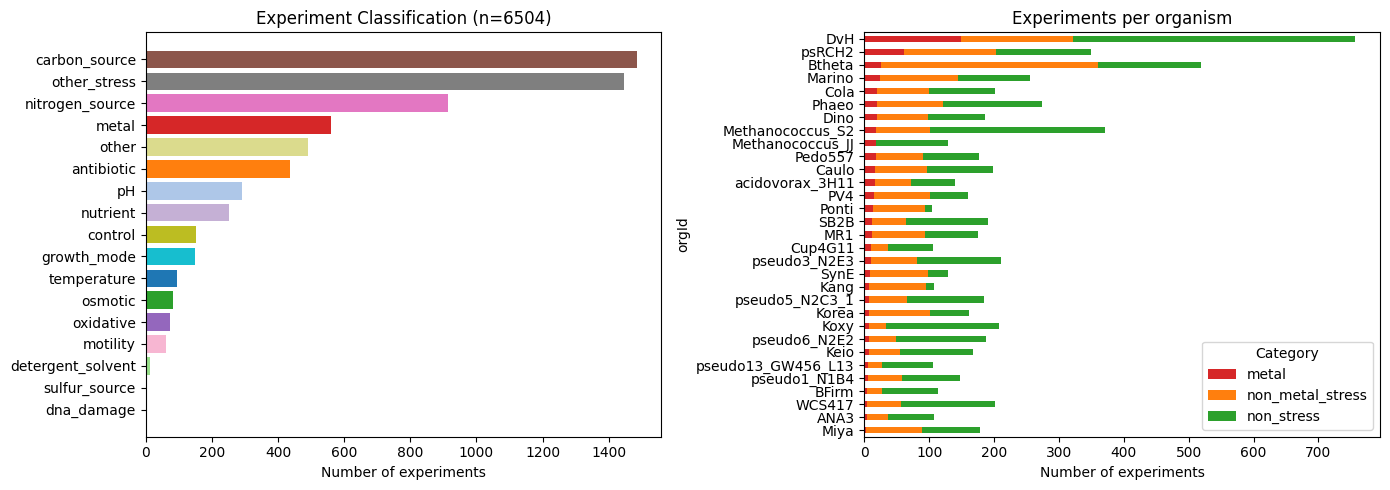

Saved: figures/experiment_classification.png


In [9]:
# Visualization: experiment category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Overall category distribution
cat_order = cat_counts.index.tolist()
colors = {'metal': '#d62728', 'antibiotic': '#ff7f0e', 'osmotic': '#2ca02c',
          'oxidative': '#9467bd', 'carbon_source': '#8c564b', 'nitrogen_source': '#e377c2',
          'other_stress': '#7f7f7f', 'control': '#bcbd22', 'growth_mode': '#17becf',
          'temperature': '#1f77b4', 'pH': '#aec7e8', 'dna_damage': '#ffbb78',
          'detergent_solvent': '#98df8a', 'nutrient': '#c5b0d5', 
          'sulfur_source': '#c49c94', 'motility': '#f7b6d2', 'other': '#dbdb8d'}
bar_colors = [colors.get(c, '#999999') for c in cat_order]
axes[0].barh(cat_order, cat_counts.values, color=bar_colors)
axes[0].set_xlabel('Number of experiments')
axes[0].set_title(f'Experiment Classification (n={len(all_exp_df)})')
axes[0].invert_yaxis()

# Panel 2: Per-organism metal vs non-metal
org_metal = all_exp_df.groupby('orgId').apply(
    lambda x: pd.Series({
        'metal': (x.stress_category == 'metal').sum(),
        'non_metal_stress': x.stress_category.isin(STRESS_CATEGORIES).sum(),
        'non_stress': x.stress_category.isin(NON_STRESS_CATEGORIES).sum()
    })
).sort_values('metal', ascending=True)

org_metal.plot.barh(stacked=True, ax=axes[1], 
                     color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[1].set_xlabel('Number of experiments')
axes[1].set_title('Experiments per organism')
axes[1].legend(title='Category', loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'experiment_classification.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: figures/experiment_classification.png')